In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
drive_path='/content/drive/MyDrive/DDD_Dataset'
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd -p {drive_path}

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown
 99% 2.56G/2.58G [00:54<00:00, 29.2MB/s]
100% 2.58G/2.58G [00:54<00:00, 50.5MB/s]


In [ ]:
!unzip /content/drive/MyDrive/DDD_Dataset/driver-drowsiness-dataset-ddd.zip

Streaming output truncated to the last 5000 lines.
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0082.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0083.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0084.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0085.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0086.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0087.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0088.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0089.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0090.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0091.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0092.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0093.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0094.png  
  inflating: Driver Drowsiness Dataset (DDD)/Non Drowsy/y0095.png

Epoch 0/14
----------
train Loss: 0.1195 Acc: 0.9493
val Loss: 0.0268 Acc: 0.9901

Epoch 1/14
----------
train Loss: 0.0377 Acc: 0.9858
val Loss: 0.0178 Acc: 0.9944

Epoch 2/14
----------
train Loss: 0.0246 Acc: 0.9912
val Loss: 0.0087 Acc: 0.9966

Epoch 3/14
----------
train Loss: 0.0200 Acc: 0.9927
val Loss: 0.0079 Acc: 0.9974

Epoch 4/14
----------
train Loss: 0.0160 Acc: 0.9937
val Loss: 0.0074 Acc: 0.9978

Epoch 5/14
----------
train Loss: 0.0141 Acc: 0.9951
val Loss: 0.0084 Acc: 0.9970

Epoch 6/14
----------
train Loss: 0.0125 Acc: 0.9952
val Loss: 0.0057 Acc: 0.9978

Epoch 7/14
----------
train Loss: 0.0145 Acc: 0.9949
val Loss: 0.0044 Acc: 0.9986

Epoch 8/14
----------
val Loss: 0.0050 Acc: 0.9984

Epoch 9/14
----------
train Loss: 0.0109 Acc: 0.9963
val Loss: 0.0042 Acc: 0.9983

Epoch 10/14
----------
train Loss: 0.0103 Acc: 0.9965
val Loss: 0.0044 Acc: 0.9982

Epoch 11/14
----------
train Loss: 0.0080 Acc: 0.9969
val Loss: 0.0024 Acc: 0.9992

Epoch 12/14
----------
train Loss

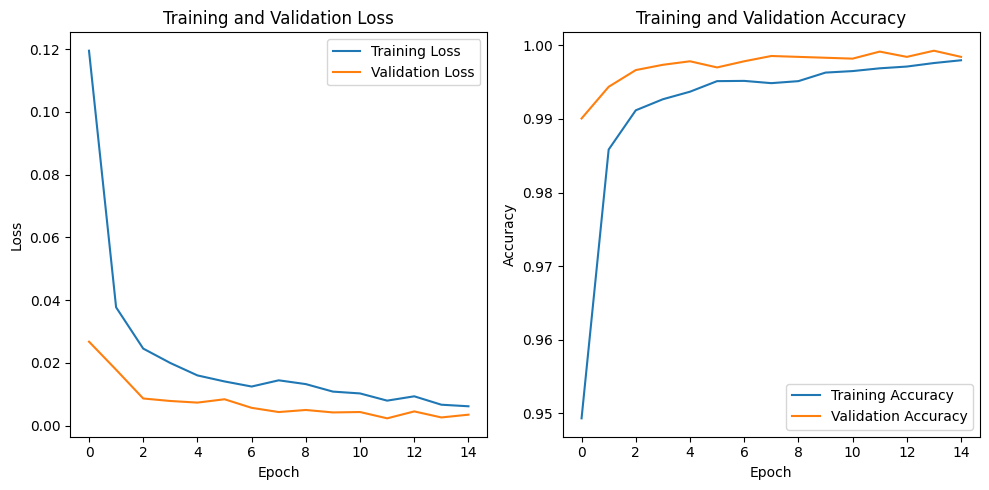

Test Accuracy: 0.9988


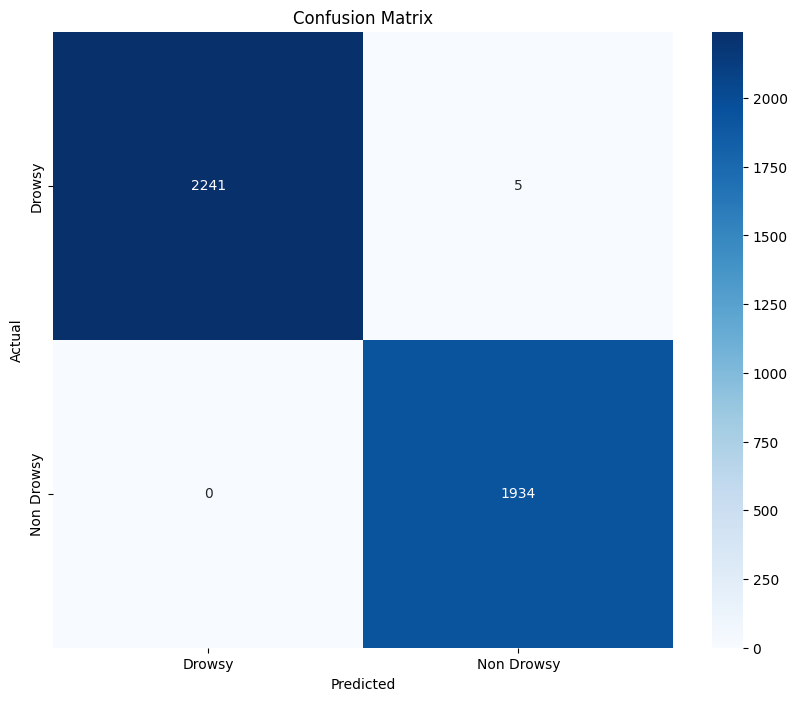

Classification Report
              precision    recall  f1-score   support

      Drowsy       1.00      1.00      1.00      2246
  Non Drowsy       1.00      1.00      1.00      1934

    accuracy                           1.00      4180
   macro avg       1.00      1.00      1.00      4180
weighted avg       1.00      1.00      1.00      4180



In [ ]:
#mobilenetv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.hub import load_state_dict_from_url
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Define MobileNetV2 model
model_urls = {
    'mobilenet_v2': 'https://download.pytorch.org/models/mobilenet_v2-b0353104.pth',
}

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

class ConvBNReLU(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1, norm_layer=None):
        padding = (kernel_size - 1) // 2
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU6(inplace=True)
        )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, norm_layer=None):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0, inverted_residual_setting=None, round_nearest=8, block=None, norm_layer=None):
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                [1, 16, 1, 1],
                [6, 24, 2, 2],
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features = [ConvBNReLU(3, input_channel, stride=2, norm_layer=norm_layer)]
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        self.features = nn.Sequential(*features)

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

def mobilenet_v2(pretrained=False, progress=True, **kwargs):
    model = MobileNetV2(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['mobilenet_v2'], progress=progress)
        model.load_state_dict(state_dict)
    return model

# Data augmentation and normalization for training, validation and test
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/Driver Drowsiness Dataset (DDD)'

# Load dataset
dataset = datasets.ImageFolder(os.path.join(data_dir), data_transforms)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained MobileNetV2 model
model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [],[]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

        print()

    return model, train_losses, val_losses, train_accs, val_accs

model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=15)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report')
print(report)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Data augmentation and normalization for training, validation, and test
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = '/content/Driver Drowsiness Dataset (DDD)'

# Load dataset
dataset = datasets.ImageFolder(os.path.join(data_dir), data_transforms)

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}
class_names = dataset.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load GoogLeNet model without pre-trained weights
model = models.googlenet(pretrained=False, aux_logits=False)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    if isinstance(outputs, tuple):
                        outputs = outputs[0]
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

        print()

    return model, train_losses, val_losses, train_accs, val_accs

model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=15)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report')
print(report)


Epoch 0/14
----------


KeyboardInterrupt: 